# Analysis of Economic Mobility
Evan Tiffany



## Introduction

Social mobility is defined as the upward movement in socioeconomic level. As this deals with socioeconomic level, there is obviously influence both in terms of social and economic factors. The factors that influence these movements have long been studied as a means to provide a more complex knowledge on what influences the future of children, and to what extent each variable matters. 
With this study, I hope to provide a reasonably accurate prediction model to assess the social mobility of an area based on certain factors provided about the area. With this, a more thorough investigation into why these factors matter can be found.

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
import random
%matplotlib inline

%pwd
dat = pd.read_csv('mobility.csv')
dat = dat.dropna()
dat[["Mobility"]] = np.log(dat[["Mobility"]])
dat[["Population"]] = np.log(dat[["Population"]])
dat[["Local_gov_spending"]] = np.log(dat[["Local_gov_spending"]])
dat[["School_spending"]] = np.log(dat[["School_spending"]])
dat[["Foreign_born"]] = np.log(dat[["Foreign_born"]])
dat = dat[["Mobility", "State", "Population", "Foreign_born", "Divorced", "Married", 
    "Labor_force_participation", "School_spending", "Test_scores", "Local_gov_spending", 
    "Gini", "Income", "Latitude", "Longitude"]]

date = dat[["Mobility", "Population","Labor_force_participation", "Local_gov_spending", "Gini", "Income"]]

## The Data

The dataset comes from a research paper titled "Where is the Land of Opportunity? The Geography of Intergenerational Mobility in the United States." published by the Quarterly Journal of Economics in 2014 and written by Chetty, Raj, Hendren, Kline and Saez. It outlines 43 variables on 741 communities nationwide, providing a mix of economic and social factors (education, home-life, racial breakdowns, etc.) for these communities. With this data, I aim to use the intersectionality of social and economic factors to help form a model that predicts areas of high social mobility. Social mobility, in this dataset, is a measurement of the proportion of those raised in a community who have moved up in terms of social class after aging. 

The data will be split to form an appropriate model, providing a training and testing data set to measure the error of the model and show how accurate the model truly is. To achieve this, I will randomly shuffle the data and extract 100 entries for the testing data and the rest will be part of the model-forming, or testing, dataset.

In [3]:
dat = dat.sample(frac=1).reset_index(drop = True)

test = dat[:100]
train = dat[100:]

## Exploratory Data Analysis

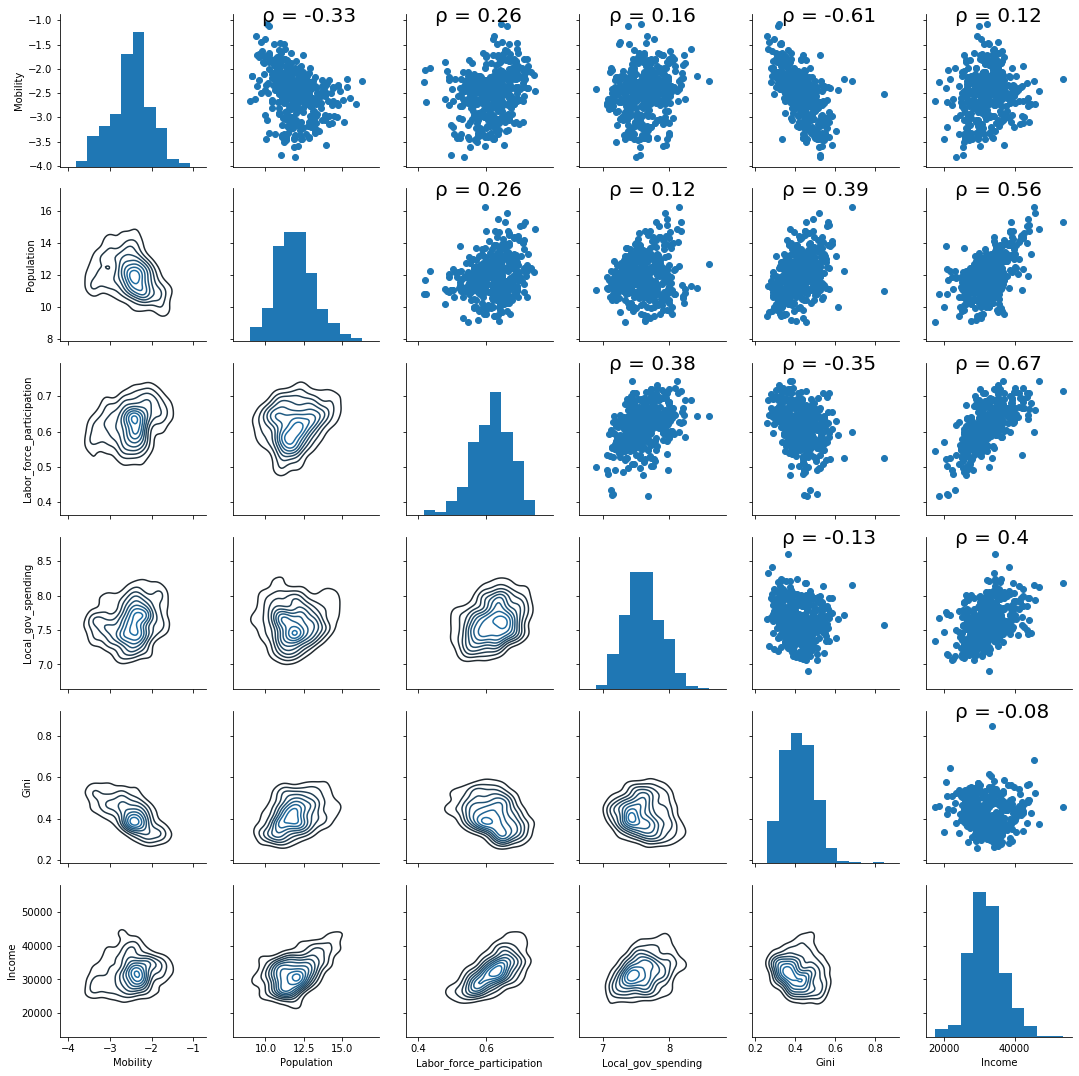

In [14]:
def corr(x, y, **kwargs):
    coef = np.corrcoef(x,y)[0][1]
    label = 'ρ = ' + str(round(coef,2))
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.95), size = 20, xycoords = ax.transAxes)

grid = sns.PairGrid(date)
grid = grid.map_upper(plt.scatter)
grid = grid.map_upper(corr)
grid = grid.map_diag(plt.hist)
grid = grid.map_lower(sns.kdeplot)

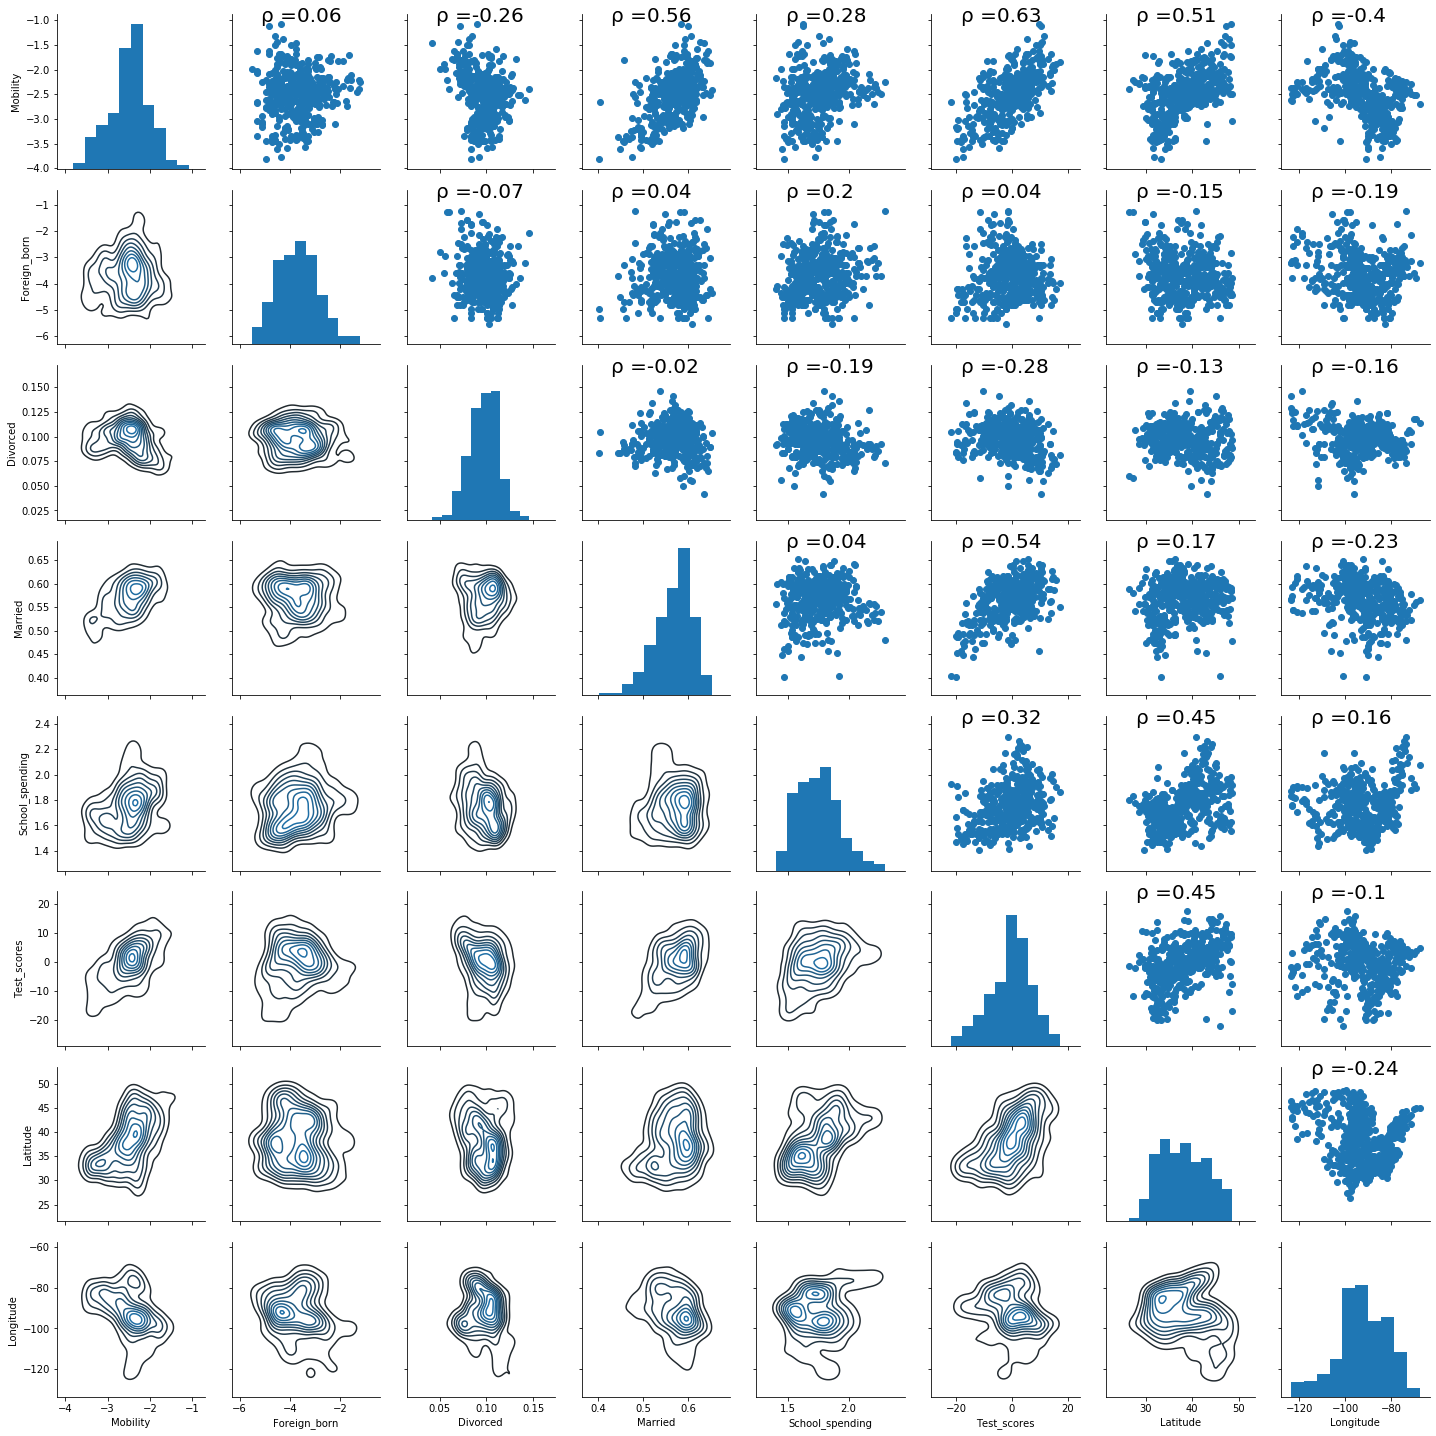

In [45]:
dats = dat[["Mobility", "Foreign_born", "Divorced", "Married", "School_spending", "Test_scores", "Latitude", "Longitude"]]

grid = sns.PairGrid(dats)
grid = grid.map_upper(plt.scatter)
grid = grid.map_upper(corr)
grid = grid.map_diag(plt.hist)
grid = grid.map_lower(sns.kdeplot)

The pairs plots above aim to show correlation between each variable and the variable of interest, mobility. The upper half shows the scatterplots of the data, where the focus is line 1, showing mobility on the y-axis and providing correlation between this and the other variables. For simplicity and time-saving reasons, I split the variables into economic and social factors to form these plots. We can see that the chosen economic factors overall have lower correlations other than population, labor force participation, and the gini index, a number defining the degree of economic segregation in an area. Overall, the social factors seemed to have higher correlations. With this, I've chosen to include the married, school spending, and test score variables as well as the location variables (latitude and longitude). 

The diagonals show the distribution of each variable. in this part, I was checking the approximate normality of each districution and making appropriate changes if necessary. I changed the mobility, population, government spending and school spending variables to logs in order to eliminate natural tendencies of these variables. Monetary and population based variables tend to be highly concentrated at lower values, so putting these on a log scale helps normalize and ease the inclusion of these variables. 

Finally, the lower part of the plots show a two-dimensional density plot to check the binormality. Again, with these plots we need to simply check the first column for the binormality of each variable against the variable of interest, mobility. All of these plots appear to show binormality, that is where there are somewhat concentric circles around one peak area. 

## Modeling

In [5]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from linearmodels.iv import IV2SLS

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


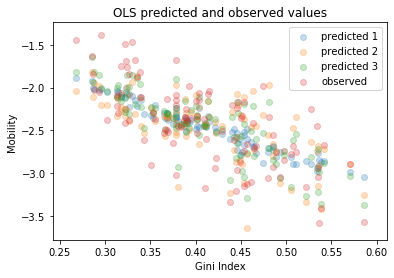

In [10]:
train['const'] = 1
test['const'] = 1
m1 = sm.OLS(endog=train['Mobility'], exog = train[['const', 'Population', 'Labor_force_participation', 'Gini']],
            missing = 'drop')
m2 = sm.OLS(endog=train['Mobility'], exog = train[['const', 'Married', 'School_spending', 'Test_scores']],
            missing = 'drop')
m3 = sm.OLS(endog=train['Mobility'], exog = train[['const', 'Population', 'Labor_force_participation', 'Gini', 'Married', 'School_spending', 'Test_scores']],
            missing = 'drop')


fit1 = m1.fit()
fit2 = m2.fit()
fit3 = m3.fit()

pred1 = fit1.predict(exog = test[['const', 'Population', 'Labor_force_participation', 'Gini']])
pred2 = fit2.predict(exog = test[['const', 'Married', 'School_spending', 'Test_scores']])
pred3 = fit3.predict(exog = test[['const', 'Population', 'Labor_force_participation', 'Gini', 'Married', 'School_spending', 'Test_scores']])

fig, ax = plt.subplots()
ax.scatter(test['Gini'], pred1, alpha=0.25,
        label='predicted 1')
ax.scatter(test['Gini'], pred2, alpha=0.25,
        label='predicted 2')
ax.scatter(test['Gini'], pred3, alpha=0.25,
        label='predicted 3')

ax.scatter(test['Gini'], test['Mobility'], alpha=0.25,
        label='observed')
ax.legend()
ax.set_title('OLS predicted and observed values')
ax.set_xlabel('Gini Index')
ax.set_ylabel('Mobility')
plt.show()

In [14]:
info_dict={'R2' : lambda x: f"{x.rsquared:.2f}",
           'N Obs' : lambda x: f"{int(x.nobs):d}"}
results_table = summary_col(results=[fit1,fit2,fit3],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Model 1',
                                         'Model 2',
                                         'Model 3'],
                            info_dict=info_dict,
                            regressor_order=['const',
                                             'Population',
                                             'Labor_force_participation',
                                             'Gini',
                                             'Married', 
                                             'School_spending'
                                             'Test_scores'])

results_table.add_title('OLS Regressions')

print(results_table)

                  OLS Regressions
                          Model 1  Model 2  Model 3 
----------------------------------------------------
const                     -1.27*** -5.59*** -4.28***
                          (0.31)   (0.39)   (0.50)  
Population                -0.07***          -0.06***
                          (0.02)            (0.02)  
Labor_force_participation 1.19***           0.62    
                          (0.45)            (0.39)  
Gini                      -2.77***          -1.21***
                          (0.33)            (0.30)  
Married                            4.28***  3.56*** 
                                   (0.53)   (0.52)  
School_spending                    0.39***  0.34*** 
                                   (0.12)   (0.11)  
Test_scores                        0.02***  0.02*** 
                                   (0.00)   (0.00)  
R2                        0.36     0.49     0.56    
N Obs                     318      318      318     
Standard err

As shown in the graphic and the table, model 3 provides the most complete model. The only included variable that doesn't appear significant in the model is labor force participation, though this is a significant predictor in the first model. 

In [18]:
mse = np.mean((test['Mobility'] - pred3)**2)

print("Mean Squared Error of Model 3 = ", mse)

Mean Squared Error of Model 3 =  0.10391655748973946


The mean squared error of .1 shows that this model provides overall a very small error in terms of prediction. 

## Conclusion

Overall, the best predictors found in the dataset were the population, gini index, labor force participation, proportion of married couples, school spending and test scores. These provided for a complete model that predicted the mobility score of an area with very small error. The modeling process shows the intersectionality of social factors and economic factors in influencing the future of a person. We see high correlations in both categroies, with the highest correlations in the social factor category. Economic factors still, however, play a big role in influencing the future of children. This model, then, could be used to better assess the probability of success on average for a person in an area, however, the individual level would not only be more variable, but would most definitely be more heavily dependent on familial economic level and social factors of the individual. A more complete model could be found with the addition of other variables, obviously, but this could also create an overcomplicated model that becomes too fit to the data. It would, however, be interesting to see if there are other variables that are important influences for mobility that aren't included in the data. 
With the variables included, we can see the influence of a stable household (marriage) and a good school system. These are two defining social factors. On an economic level, a higher labor force participation and lower gini index are important to increase mobility. Therefore, income equality and high labor force highly affect a person's outcome. These all lean toward a more stable environment. 